The goal of this project is to train a ResNet-18 model on the CIFAR
100 dataset, apply quantization-aware training (QAT), and deploy it on a
 Kria KV260 FPGA board.

 While ResNet-18 was initially trained on the
 ImageNet-1k dataset, for this assignment, you can either
 * (1) train it from scratchon CIFAR-100 (less recommended) or
 * (2) use ImageNet pre-trained weights to initialize the model for training on CIFAR-100

# Part 1: Structure


The architecture components are listed as follows:
* Convolution(64, 7, 2, 3)
* Batch Normalization (BN)
* ReLU Activation
* Max Pooling(3, 2, 1)

* BasicBlock(64, 3, 1, 1) x 2
* BasicBlock(128, 3, 2, 1) x 2
* BasicBlock(256, 3, 1, 1) x 2
* BasicBlock(512, 3, 2, 1) x 2

* Average Pooling 2D (7, 1, 0)
* Linear Layer (64, 10)



### Setup

In [1]:
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import pandas as pd
import time
!pip install ptflops
from ptflops import get_model_complexity_info

### Quantization: Fixed-Point QAT

In [2]:
# Weights Quantizing
def fixed_point_quantize_weights(weights, total_bits, int_bits):
    frac_bits = total_bits - int_bits
    delta = 2 ** (-frac_bits)
    max_val = (2 ** (int_bits - 1) - 1) * delta
    min_val = -2 ** (int_bits - 1) * delta

    q_weights = torch.clamp(torch.round(weights / delta), min_val / delta, max_val / delta) * delta
    return q_weights

# Weight QAT using the same fixed_point_quantize_weights function
class Conv2dFixedPoint(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        self.integral = kwargs.pop("integral", 2)
        self.fractional = kwargs.pop("fractional", 6)
        self.quant_func = fixed_point_quantize_weights
        super(Conv2dFixedPoint, self).__init__(*args, **kwargs)

    def forward(self, input_):
        weight = self.quant_func(self.weight, self.integral +self.fractional , self.integral)

        out =  F.conv2d(
            input_,
            weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
            )
        return out

# Activation Quantizing
def fixed_point_quantize_activations(activations, total_bits, int_bits):
    frac_bits = total_bits - int_bits
    delta = 2 ** (-frac_bits)
    max_val = (2 ** int_bits - 1) * delta
    min_val = 0.0  # Assuming activations are non-negative

    q_activations = torch.clamp(torch.round(activations / delta), min_val / delta, max_val / delta) * delta
    return q_activations

### Basic Block

In [3]:
class BasicBlock(nn.Module):
    expansion = 1  # No expansion in BasicBlock

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.stride = stride

        # First convolutional layer
        self.conv1 = Conv2dFixedPoint(
            in_channels, out_channels,
            kernel_size=kernel_size, stride=stride, padding=padding, bias=False,
            integral=2, fractional=6  # Specify quantization parameters
        )

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Second convolutional layer
        self.conv2 = Conv2dFixedPoint(
            out_channels, out_channels,
            kernel_size=kernel_size, stride=1, padding=padding, bias=False,
            integral=2, fractional=6  # Specify quantization parameters
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Downsample layer for shortcut connection (if needed)
        self.downsample = downsample

    def forward(self, x):
        identity = x  # Save the input tensor for the shortcut

        # First layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = fixed_point_quantize_activations(out, total_bits=8, int_bits=2)

        # Second layer
        out = self.conv2(out)
        out = self.bn2(out)

        # Apply downsampling to the identity if necessary
        if self.downsample is not None:
            identity = self.downsample(x)

        # Add the identity (shortcut connection)
        out += identity
        out = self.relu(out)
        out = fixed_point_quantize_activations(out, total_bits=8, int_bits=2)  # Quantize activations

        return out

### ResNet18

In [4]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet18, self).__init__()

        # Initial Convolution and Max Pool
        self.conv1 = Conv2dFixedPoint(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False, integral=2, fractional=6)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Define layers using your BasicBlock
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)


        # Adaptive Average Pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                Conv2dFixedPoint(in_channels, out_channels, kernel_size=1, stride=stride, bias=False, integral=2, fractional=6),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride=stride, downsample=downsample))
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, Conv2dFixedPoint):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

# Part 2: Check Usage

Calculate the number of trainable parameters, the minimum required onchip memory (in MB), the number of FLOPs (Floating Point Operations),
and the model’s latency on both GPU and CPU.

## Calculate the number of trainable parameters

In [ ]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Trainable Parameters: {total_params}")
    return total_params

model = ResNet18()
count_parameters(model)

Total Trainable Parameters: 11689512


11689512

## Calculate the minimum required on-chip memory (in MB)

In [ ]:
# Model size in MB
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement()  # param.element_size() after quantization will be 8-bit = 1 Byte
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement()  # buffer.element_size() after quantization will be 8-bit = 1 Byte
    model_size = (param_size + buffer_size) / 1000 ** 2  # Convert to MB
    print(f"Model Size: {model_size:.2f} MB")
    return model_size

def get_param_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement()  # param.element_size() after quantization will be 8-bit = 1 Byte
    model_param_size = param_size / 1000 ** 2  # Convert to MB
    print(f"Parameter Size: {model_param_size:.2f} MB")
    return model_param_size

def get_buffer_size(model):
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement()  # buffer.element_size() after quantization will be 8-bit = 1 Byte
    model_buffer_size = buffer_size / 1000 ** 2  # Convert to MB
    print(f"Buffer Size: {model_buffer_size:.2f} MB")
    return model_buffer_size

model = ResNet18()
get_model_size(model)
get_param_size(model)
get_buffer_size(model)

Model Size: 11.70 MB
Parameter Size: 11.69 MB
Buffer Size: 0.01 MB


0.00962

## Calculate the number of Multiply-Accumulate operations (MACs)

In [ ]:
def compute_flops(model, input_res=32):
    macs, params = get_model_complexity_info(
        model, (3, input_res, input_res), as_strings=True,
        print_per_layer_stat=False, verbose=False
    )
    print(f"Computational Complexity (MACs): {macs}")
    print(f"Number of Parameters: {params}")

model = ResNet18()
compute_flops(model)

Computational Complexity (MACs): 742.38 KMac
Number of Parameters: 11.69 M


## Calculate the model’s latency on both GPU and CPU

In [ ]:
def measure_inference_time(model, device='cpu', input_size=(1, 3, 32, 32), num_runs=100):
    model.eval()
    model.to(device)   # IMPORTANT
    input_tensor = torch.randn(input_size).to(device) # IMPORTANT

    # Warm-up runs
    with torch.no_grad():
        for _ in range(10):
            _ = model(input_tensor)

    # Timing runs
    timings = []
    with torch.no_grad():
        for _ in range(num_runs):
            start_time = time.time()
            _ = model(input_tensor)
            end_time = time.time()
            timings.append(end_time - start_time)

    avg_time_per_run = sum(timings) / num_runs
    throughput = input_size[0] / avg_time_per_run

    print(f"Average Inference Time: {avg_time_per_run * 1000:.2f} ms")
    print(f"Throughput: {throughput:.2f} samples/sec")

model = ResNet18()
print(f"Latency on GPU")
measure_inference_time(model, device='cuda', input_size=(1, 3, 224, 224))
print(f"Latency on CPU")
measure_inference_time(model, device='cpu', input_size=(1, 3, 224, 224))

Latency on GPU
Average Inference Time: 4.82 ms
Throughput: 207.65 samples/sec
Latency on CPU
Average Inference Time: 146.66 ms
Throughput: 6.82 samples/sec


## BottleNeck Check for each components

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

model = model.eval()
inputs = torch.randn(5, 3, 224, 224)

with profile(activities=[ProfilerActivity.CPU], profile_memory=True, record_shapes=True) as prof:
    with record_function("model_inference"):
        model(inputs)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))
print(type(model))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference         2.34%      12.113ms       100.00%     517.298ms     517.298ms           0 b    -391.50 Mb             1  
                     aten::conv2d         0.04%     206.595us        61.42%     317.704ms      15.885ms      47.37 Mb           0 b            20  
                aten::convolution         0.08%     426.250us        61.38%     317.497ms      15.875ms      47.37 Mb           0 b            20  
               aten::_convolution         0.06%     299.945us        61.29%     317.071ms      15.854ms      47.

# Part 3: Set Dataset

## Download the CIFAR-100 dataset, resizing and create a validation set

Files already downloaded and verified
Files already downloaded and verified


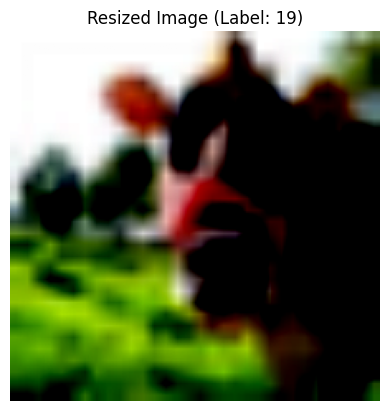

Files already downloaded and verified


(-0.5, 31.5, 31.5, -0.5)

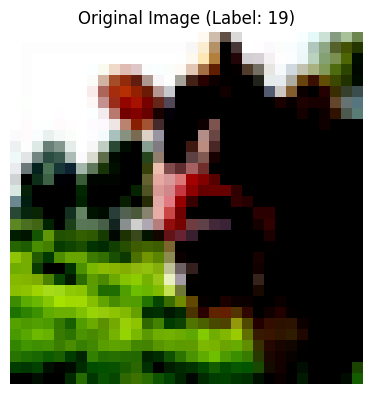

In [ ]:
# Resize CIFAR100 (32 x 32) into (224 x 224)
transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Full training dataset
full_train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, transform=transform, download=True)

# Split into training and validation sets (95-5 split)
train_size = int(0.95 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Print one resized image
image, label = full_train_dataset[0]
image_np = image.permute(1, 2, 0).numpy()
plt.imshow(image_np)
plt.title(f"Resized Image (Label: {label})")
plt.axis('off')  # Hide axis ticks and labels
plt.show()

# Print one unsized image
original_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
original_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, transform=original_transform, download=True)
original_image, label = original_dataset[0]  # Get the first image
original_image_np = original_image.permute(1, 2, 0).numpy()
plt.figure(figsize=(10, 5))  # Adjust figure size if needed
plt.subplot(1, 2, 1)  # Create a subplot for the original image
plt.imshow(original_image_np)
plt.title(f"Original Image (Label: {label})")
plt.axis('off')


## Define a search space for hyperparameters (learning rate, batch size)

In [ ]:
# Define hyperparameter grid
learning_rates = [0.1, 0.05, 0.025, 0.01]
batch_sizes = [16, 32, 64, 128]

##  Find the optimal set of hyperparameters based on validation performance

In [ ]:
def train(model, device, train_loader, optimizer, criterion, scheduler, epoch):
       model.train()
       epoch_losses = [] # Store losses for this epoch
       for batch_idx, (data, target) in enumerate(train_loader):
           data, target = data.to(device), target.to(device)
           optimizer.zero_grad()
           output = model(data)
           loss = criterion(output, target)
           loss.backward()
           optimizer.step()
           epoch_losses.append(loss.item())

       # Calculate average loss for the epoch
       avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
       train_losses.append(avg_epoch_loss)  # Append to overall losses
       scheduler.step()  # Update learning rate using the scheduler

def evaluate(model, device, val_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(val_loader.dataset)
    return accuracy

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define loss function
criterion = nn.CrossEntropyLoss()

# Hyperparameter tuning loop
best_accuracy = 0
best_params = {}
num_epochs = 3

for lr in learning_rates:
    for batch_size in batch_sizes:
        # Create data loaders with the current batch size
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize the model and optimizer
        model = models.resnet18(pretrained=True).to(device) # move model to GPU
        optimizer = optim.SGD(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

        # Train the model
        for epoch in range(num_epochs):  # Use a few epochs for demonstration
            train(model, device, train_loader, optimizer, criterion, scheduler, epoch)

        # Evaluate the model on the validation set
        accuracy = evaluate(model, device, val_loader)
        print(f'Learning Rate: {lr}, Batch Size: {batch_size}, Validation Accuracy: {accuracy:.2f}%')

        # Update best hyperparameters
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'learning_rate': lr, 'batch_size': batch_size}

print(f'Best Validation Accuracy: {best_accuracy:.2f}% with Parameters: {best_params}')

Learning Rate: 0.1, Batch Size: 16, Validation Accuracy: 70.16%
Learning Rate: 0.1, Batch Size: 32, Validation Accuracy: 74.80%
Learning Rate: 0.1, Batch Size: 64, Validation Accuracy: 76.88%
Learning Rate: 0.1, Batch Size: 128, Validation Accuracy: 76.32%
Learning Rate: 0.05, Batch Size: 16, Validation Accuracy: 75.96%
Learning Rate: 0.05, Batch Size: 32, Validation Accuracy: 77.68%
Learning Rate: 0.05, Batch Size: 64, Validation Accuracy: 75.80%
Learning Rate: 0.05, Batch Size: 128, Validation Accuracy: 73.60%
Learning Rate: 0.025, Batch Size: 16, Validation Accuracy: 78.36%
Learning Rate: 0.025, Batch Size: 32, Validation Accuracy: 77.76%
Learning Rate: 0.025, Batch Size: 64, Validation Accuracy: 74.56%
Learning Rate: 0.025, Batch Size: 128, Validation Accuracy: 69.56%
Learning Rate: 0.01, Batch Size: 16, Validation Accuracy: 75.80%
Learning Rate: 0.01, Batch Size: 32, Validation Accuracy: 72.92%
Learning Rate: 0.01, Batch Size: 64, Validation Accuracy: 67.32%
Learning Rate: 0.01, B

# Part 4: Training

Train your model on the full training set using the identified best hyperparameters until convergence (90 epochs are suggested). Report the model’s performance on the CIFAR-100 test set and plot the training curve that shows loss versus training iterations.

Test Accuracy with Best Parameters: 79.45%


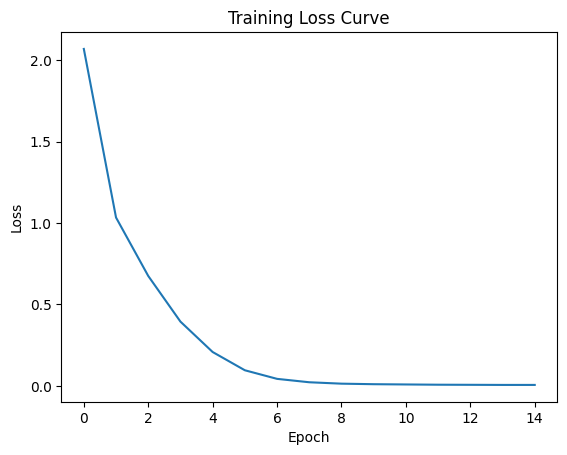

In [ ]:
# Result from test
best_params = {'learning_rate': 0.025, 'batch_size': 16}
num_epochs = 15

# Fixed-Point Quantization applied Post Training
total_bits = 8  # Total number of bits
int_bits = 2    # Number of bits for integer part

# Re-train on the full training set using the best hyperparameters
train_loader = DataLoader(full_train_dataset, batch_size=best_params['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

# Initialize the model and optimizer with the best hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=best_params['learning_rate'])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Train the model on the full training set
train_losses = []
for epoch in range(num_epochs):
    train(model, device, train_loader, optimizer, criterion, scheduler, epoch)

# Evaluate on the test set
test_accuracy = evaluate(model, device, test_loader)
print(f'Test Accuracy with Best Parameters: {test_accuracy:.2f}%')

# Plot the learning curve
plt.plot(train_losses)
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Part 5: Inference

Visualize a few random samples from the test set along with their predicted labels. Include examples where the model has made incorrect predictions.

In [ ]:
num_samples = 5
sample_indices = random.sample(range(len(test_dataset)), num_samples)
samples = [test_dataset[i] for i in sample_indices]

# Make predictions
model.eval()
with torch.no_grad():
    inputs = torch.stack([s[0] for s in samples]).to(device)
    outputs = model(inputs)
    predicted_labels = outputs.argmax(dim=1).cpu().numpy()

# Plot samples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Predictions (Correct and Incorrect)', fontsize=16)

for i, (sample, pred_label) in enumerate(zip(samples, predicted_labels)):
    image = image[0].permute(1, 2, 0)
    image, true_label = sample

# Plot the image using matplotlib
    ax.imshow(image)
    ax.axis('off')  # Hide axis
    ax.set_title(f'Prediction: {pred_label}, True: {true_label}')
    plt.show()